<a href="https://colab.research.google.com/github/ankit-kothari/Scan-with-OpenCV/blob/master/scan_with_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the Image to be scanned

1. Load the image
2. The default setting of the color mode in OpenCV comes in the order of BGR, which is different from that of Matplotlib. Therefore to see the image in GRAYSCALE mode, we need to convert it from BGR to GRAYSCALE as follows.
3. Convert it into a grayscale image
4. Use the bilateralFiletr function to blur the image 



 image size (960, 720, 3)
Original Image


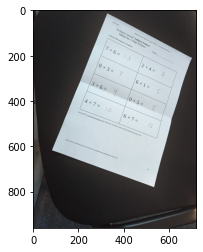

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/content/drive/My Drive/images/scan.jpg')
h,w,_ = image.shape
print(f' image size {image.shape}')
print(f'Original Image')
plt.imshow(image, cmap='gray')
plt.show()

Gray Scale and Denoised Image


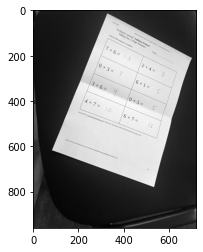

In [ ]:
print(f'Gray Scale and Denoised Image')
image = cv2.bilateralFilter(image, 9, 75, 75)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#gray = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(gray, cmap='gray')
plt.show()

Image De-noising - Non-Local Means Denoising

1. Parameters, after None are - the filter strength 'h' (5-10 is a good range)
2. Next is hForColorComponents, set as same value as h again

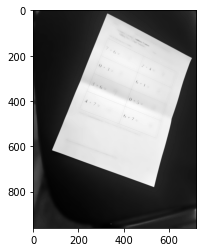

In [ ]:
dst = cv2.fastNlMeansDenoising(gray, None, 40, 7, 21)
plt.imshow(dst, cmap='gray')
plt.show()

Image Thresholding

1. In thresholding, we convert a grey scale image to it's binary form
2. 

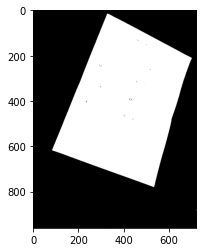

In [ ]:
ret,thresh1 = cv2.threshold(dst, 127, 255, cv2.THRESH_BINARY) 
plt.imshow(thresh1, cmap='gray')
plt.show()

EDGE DETECTION

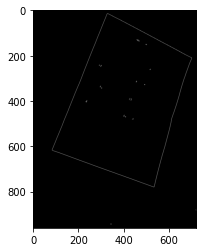

In [ ]:
edged = cv2.Canny(thresh1, 75,200)
plt.imshow(edged, cmap='gray')
plt.show()

MORPHOLOGICAL TRANSFORMATION

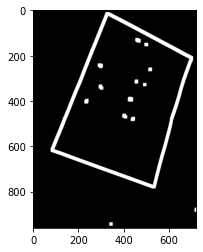

In [ ]:
# Let's define our kernel size
kernel = np.ones((3,3), np.uint8)

dilation = cv2.dilate(edged, kernel, iterations = 6)
plt.imshow(dilation, cmap='gray')
plt.show()

1. The cv2.findContours function  stores a numpy array of (x,y) points that forms the contour.
2. Retrieval Mode:
*   cv2.CHAIN_APPROX_NONE – Stores all the points along the line
*   cv2.CHAIN_APPROX_SIMPLE – Stores the end points of each line
3. Sort the contours by Area to get the top 4 conturs, i.e the edges in the image
4. using approxpolyDP function is used to approximate the contour, with approximation accuracy, and closed (True or False) polygon. 

CONTOUR DETECTION

3
4
success


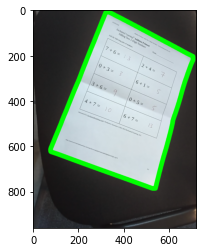

77 9 626 777


In [ ]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts = sorted(contours, key = cv2.contourArea, reverse = True)[0:5]
print(len(cnts))
# Extract Contours
for cnt in cnts:
    
    # Get approximate polygons
    approx = cv2.approxPolyDP(cnt, 0.11*cv2.arcLength(cnt,True),True)
    print(len(approx))
    if len(approx) == 4:
        x,y,w,h = cv2.boundingRect(cnt)
        shape_name = "Square"
        print("success")
        cv2.drawContours(image,[cnt],-2,(0,255,0),20)
        plt.imshow(image, cmap='gray')
        plt.show()
        break
print(x,y,w,h)
#plt.imshow(warped, cmap='gray')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROIdimensions=approx
ROIdimensions.shape

(4, 1, 2)

In [ ]:
approx

array([[[321,   9]],

       [[ 77, 622]],

       [[537, 785]],

       [[702, 204]]], dtype=int32)

In [ ]:
vertice = approx.ravel()
vertice = vertice.reshape(4,2)
vertice

array([[321,   9],
       [ 77, 622],
       [537, 785],
       [702, 204]], dtype=int32)

In [ ]:
points=[]
for i in vertice:
    print(i)
    x=i[0]
    y=i[1]
    points.append([x,y])
points

[321   9]
[ 77 622]
[537 785]
[702 204]


[[321, 9], [77, 622], [537, 785], [702, 204]]

PERSPECTIVE FROM AFFINE TRANSFORMATION

In [ ]:
# reshape coordinates array
ROIdimensions = ROIdimensions.reshape(4,2)
# list to hold ROI coordinates
rect = np.zeros((4,2), dtype="float32")
# top left corner will have the smallest sum, 
# bottom right corner will have the largest sum
s = np.sum(ROIdimensions, axis=1)
rect[0] = ROIdimensions[np.argmin(s)]
rect[2] = ROIdimensions[np.argmax(s)]
# top-right will have smallest difference
# botton left will have largest difference
diff = np.diff(ROIdimensions, axis=1)
rect[1] = ROIdimensions[np.argmin(diff)]
rect[3] = ROIdimensions[np.argmax(diff)]
# top-left, top-right, bottom-right, bottom-left
(tl, tr, br, bl) = rect
# compute width of ROI
widthA = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2 )
widthB = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2 )
maxWidth = max(int(widthA), int(widthB))
# compute height of ROI
heightA = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2 )
heightB = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2 )
maxHeight = max(int(heightA), int(heightB))

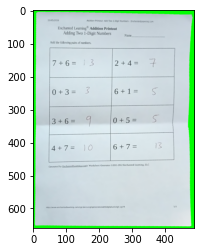

In [ ]:
# Set of destinations points for "birds eye view"
# dimension of the new image
dst = np.array([
    [0,0],
    [maxWidth, 0],
    [maxWidth, maxHeight],
    [0, maxHeight]], dtype="float32")
# compute the perspective transform matrix and then apply it
transformMatrix = cv2.getPerspectiveTransform(rect, dst)
# transform ROI
scan = cv2.warpPerspective(image, transformMatrix, (maxWidth, maxHeight))
# lets see the wraped document

plt.imshow(scan, cmap='gray')
plt.show()

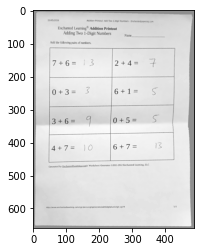

In [ ]:
# convert to gray
scanGray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
# display final gray image
plt.imshow(scanGray, cmap='gray')
plt.show()
# ------------------------------


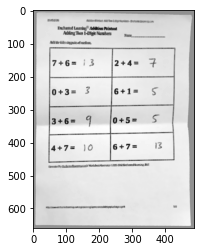

In [ ]:
kernel = np.ones((3,3), np.uint8)
sharpened = cv2.erode(scanGray, kernel, iterations = 1)
plt.imshow(sharpened, cmap='gray')
plt.show()